In [1]:
import sys
sys.path.append('/Users/zhengj10/Python/Modules')
import h5py
import os
import numpy as np
from skimage.io import imsave
import matplotlib.pyplot as plt
import yaml
import pandas as pd
import PatcherBot as pb
from glob import glob
import seaborn as sns
import tifffile as tff
import scipy.signal as ss

### Function to get Rs (bridge resistance) from patch.log

In [2]:
def get_Rs(logFile):
    params = {}

    keep_phrase = "whole cell"
    with open(logFile) as f:
        lines_no = []
        for i, line in enumerate(f):
            if keep_phrase in line:
                lines_no.append(i)

    with open(logFile) as f:
        Rs = []
        et = [] # event time
        for i, line in enumerate(f):
            if lines_no[0]<i<lines_no[1]:
                try:
                    Rs.append(eval(line)["peakResistance"])
                    et.append(eval(line)["event_time"])
                except:
                    continue
    
    params['Lines_no'] = np.array(lines_no)
    params['Rs'] = np.array(Rs)/1e6
    params['Event_time'] = np.array(et)
    return params


### Load params

In [3]:
# sumPath = '/Volumes/genie/Jihong_GENIE_stuff/PatcherBot/summary/Voltron2_paper'
imgPath = '/Volumes/genie/BenArthur/patch-screen/bot'
rawPath = '/Volumes/genie/Jihong_GENIE_stuff/PatcherBot/raw'
# sumPath = '/Users/zhengj10/Desktop/GENIE/Manuscript/Voltron 2 paper/Voltron 2 paper_v7'
sumPath = '/Volumes/genie/Jihong_GENIE_stuff/Ace based sensors/I-Clamp'

# imgPath = '/Volumes/Backup Plus/patch-screen/bot'
# rawPath = '/Volumes/Backup Plus/PatcherBot/raw'

# sumPath = '/Users/zhengj10/Desktop/Voltron2/iclamp'
# imgPath = '/Volumes/Backup Plus/patch-screen/bot'
# rawPath = '/Volumes/Backup Plus/PatcherBot/raw'
print(os.path.exists(sumPath))
print(os.path.exists(imgPath))
print(os.path.exists(rawPath))


True
True
True


In [4]:
# datePath = pb.getPathInfo(imgPath)
datePath = ['2022.10.12_000','2022.10.13_000']
# datePath = datePath[9:]
datePath


['2022.10.12_000', '2022.10.13_000']

### Getting dFF from raw data with self - defined active pixels:
- active pixels: central 60x41 pixels that exceeds 2/3 highest pixcel value

In [5]:
def get_dff(dataFile):
    data = h5py.File(dataFile,'r')
    trace = data['data'][()]
    ref = np.mean(trace[10:60,:,:],axis=0)
    fb = np.min(ref)
    crop = ref[224:284,:]
    max_val = np.max(crop)
    act_pix = crop > (fb + (max_val-fb)*0.67)
    f = []
    for frame in range(trace.shape[0]):
        f_single_frame = np.sum(trace[frame,224:284,:]*act_pix)/np.sum(act_pix)
        f.append(f_single_frame)
    f_peak = np.min(f)
    f_peak_idx = np.argmin(f)
#     print ('peak idx: %s' %(f_peak_idx))
    f0 = np.mean(f[f_peak_idx-40:f_peak_idx-20])
    f = np.array(f)
    dff = (f-f0)/(f0-fb)
    dff_peak = (f_peak-f0)/(f0-fb)
    return dff,dff_peak,f_peak_idx,f,f0
#     return dff


In [6]:
# wrongPlates = ['/Volumes/Backup Plus/PatcherBot/raw/2020.10.29_000/plate_001']
# # e.g. plate with different protocol

# badTrials = ['/Volumes/Backup Plus/PatcherBot/raw/2020.10.06_000/plate_000/patch_attempt_0011_000',
#             '/Volumes/Backup Plus/PatcherBot/raw/2020.09.23_000/plate_003/patch_attempt_0019_000']
# # bad trials idendified during experiment: e.g. wrong power, no AP that cannot be excluded within dataframe

# wrongPlates = []
# # e.g. plate with different protocol

# badTrials = ['/Volumes/genie/Jihong_GENIE_stuff/PatcherBot/raw/2022.06.01_001/plate_002/patch_attempt_0013_000',
#             '/Volumes/genie/Jihong_GENIE_stuff/PatcherBot/raw/2022.06.01_001/plate_003/patch_attempt_0012_000',
#             '/Volumes/genie/Jihong_GENIE_stuff/PatcherBot/raw/2022.06.01_001/plate_004/patch_attempt_0027_000',
#             '/Volumes/genie/Jihong_GENIE_stuff/PatcherBot/raw/2022.06.01_001/plate_005/patch_attempt_0010_000']
# # bad trials idendified during experiment: e.g. wrong power, no AP that cannot be excluded within dataframe

# wrongPlates = []
# # e.g. plate with different protocol

# badTrials = ['/Volumes/genie/Jihong_GENIE_stuff/PatcherBot/raw/2022.06.02_000/plate_000/patch_attempt_0006_000',
#             '/Volumes/genie/Jihong_GENIE_stuff/PatcherBot/raw/2022.06.02_000/plate_001/patch_attempt_0003_000']
# # bad trials idendified during experiment: e.g. wrong power, no AP that cannot be excluded within dataframe

wrongPlates = []
# e.g. plate with different protocol

badTrials = ['/Volumes/genie/Jihong_GENIE_stuff/PatcherBot/raw/2022.10.12_000/plate_000/patch_attempt_0013_000',
            '/Volumes/genie/Jihong_GENIE_stuff/PatcherBot/raw/2022.10.12_000/plate_001/patch_attempt_0020_000',
            '/Volumes/genie/Jihong_GENIE_stuff/PatcherBot/raw/2022.10.12_000/plate_004/patch_attempt_0012_000',
            '/Volumes/genie/Jihong_GENIE_stuff/PatcherBot/raw/2022.10.12_000/plate_004/patch_attempt_0060_000',
            '/Volumes/genie/Jihong_GENIE_stuff/PatcherBot/raw/2022.10.13_000/plate_001/patch_attempt_0020_000',
            '/Volumes/genie/Jihong_GENIE_stuff/PatcherBot/raw/2022.10.13_000/plate_002/patch_attempt_0045_000',
            '/Volumes/genie/Jihong_GENIE_stuff/PatcherBot/raw/2022.10.13_000/plate_003/patch_attempt_0052_000']
# bad trials idendified during experiment: e.g. wrong power, no AP that cannot be excluded within dataframe

In [7]:
data_all={}

data_all['Date'] = []
data_all['Plate'] = []
data_all['Well'] = []
data_all['Cell'] = []
data_all['Mutation'] = []
data_all['Transfected_date'] = []
data_all['dFF_Ben'] = []
data_all['Pulse_amplitude (nA)'] = []
data_all['Pulse_duration (ms)'] = []

for date in datePath:
    platePath = pb.getPathInfo(os.path.join(rawPath,date))
    for plate in platePath:
        if os.path.join(rawPath,date,plate) in wrongPlates:
            print('wrong plate: %s' %os.path.join(rawPath, date, plate))
            continue
            
        idxFile = os.path.join(rawPath,date,plate,'.index')
        meta = yaml.load(open(idxFile), Loader=yaml.FullLoader)
        cellPath = pb.getPathInfo(os.path.join(rawPath, date, plate))
#         print(cellPath)
        for cell in(cellPath):
            if os.path.join(rawPath,date,plate,cell) in badTrials:
                print('bad trials: %s' %os.path.join(rawPath,date,plate,cell))
                continue
                
            print(os.path.join(rawPath, date, plate, cell))
            if not os.path.exists(os.path.join(rawPath,date,plate,cell,'I_clamp1_000')):
                continue

            logFile = os.path.join(rawPath, date, plate, cell, 'patch.log')
            params = get_Rs(logFile)
            Rs = np.mean(params['Rs'][-30:-10])
            
            dFF_all_Ben = []
            dFF_all_norm_Ben = []

            matFile = os.path.join(imgPath, date, plate, cell, '999.mat')
            f = h5py.File(matFile,'r')
            d = f['params']['fit']
            st = d[0]
            obj = f[st]
            dFF = obj['bkg_norm_ave_dFoF0'][()][0]
            dFF_trace = obj['bleach_bkg_norm_ave_trace'][()]
            
            dFF_all_Ben.append(dFF)

            dFF_mean_Ben = np.nanmean(dFF_all_Ben)


            mutation = meta['.']['mutation_1']
            
            

            note = meta['.']['notes'][0:6]
            data_all['Date'].append(date)
            data_all['Plate'].append(plate)
            data_all['Well'].append('well_1')
            data_all['Cell'].append(cell)
            data_all['Mutation'].append(mutation)
            data_all['Transfected_date'].append(note[:6])
            data_all['dFF_Ben'].append(dFF_mean_Ben)
            data_all['Pulse_amplitude (nA)'].append(2)
            data_all['Pulse_duration (ms)'].append(2)
            
print('done')

/Volumes/genie/Jihong_GENIE_stuff/PatcherBot/raw/2022.10.12_000/plate_000/patch_attempt_0000_000
/Volumes/genie/Jihong_GENIE_stuff/PatcherBot/raw/2022.10.12_000/plate_000/patch_attempt_0001_000
/Volumes/genie/Jihong_GENIE_stuff/PatcherBot/raw/2022.10.12_000/plate_000/patch_attempt_0002_000
/Volumes/genie/Jihong_GENIE_stuff/PatcherBot/raw/2022.10.12_000/plate_000/patch_attempt_0003_000
/Volumes/genie/Jihong_GENIE_stuff/PatcherBot/raw/2022.10.12_000/plate_000/patch_attempt_0004_000
/Volumes/genie/Jihong_GENIE_stuff/PatcherBot/raw/2022.10.12_000/plate_000/patch_attempt_0005_000
/Volumes/genie/Jihong_GENIE_stuff/PatcherBot/raw/2022.10.12_000/plate_000/patch_attempt_0006_000
/Volumes/genie/Jihong_GENIE_stuff/PatcherBot/raw/2022.10.12_000/plate_000/patch_attempt_0007_000
/Volumes/genie/Jihong_GENIE_stuff/PatcherBot/raw/2022.10.12_000/plate_000/patch_attempt_0008_000
/Volumes/genie/Jihong_GENIE_stuff/PatcherBot/raw/2022.10.12_000/plate_000/patch_attempt_0009_000
/Volumes/genie/Jihong_GENIE_st

/var/folders/87/trl8ql4s7vj6fkdtrrkcwx6s0zb2d2/T/ipykernel_4671/836035523.py:50: RuntimeWarning: Mean of empty slice
  dFF_mean_Ben = np.nanmean(dFF_all_Ben)


/Volumes/genie/Jihong_GENIE_stuff/PatcherBot/raw/2022.10.13_000/plate_000/patch_attempt_0011_000
/Volumes/genie/Jihong_GENIE_stuff/PatcherBot/raw/2022.10.13_000/plate_000/patch_attempt_0012_000
/Volumes/genie/Jihong_GENIE_stuff/PatcherBot/raw/2022.10.13_000/plate_000/patch_attempt_0013_000
/Volumes/genie/Jihong_GENIE_stuff/PatcherBot/raw/2022.10.13_000/plate_000/patch_attempt_0014_000
/Volumes/genie/Jihong_GENIE_stuff/PatcherBot/raw/2022.10.13_000/plate_000/patch_attempt_0015_000
/Volumes/genie/Jihong_GENIE_stuff/PatcherBot/raw/2022.10.13_000/plate_000/patch_attempt_0016_000
/Volumes/genie/Jihong_GENIE_stuff/PatcherBot/raw/2022.10.13_000/plate_001/patch_attempt_0017_000
/Volumes/genie/Jihong_GENIE_stuff/PatcherBot/raw/2022.10.13_000/plate_001/patch_attempt_0018_000
/Volumes/genie/Jihong_GENIE_stuff/PatcherBot/raw/2022.10.13_000/plate_001/patch_attempt_0019_000
bad trials: /Volumes/genie/Jihong_GENIE_stuff/PatcherBot/raw/2022.10.13_000/plate_001/patch_attempt_0020_000
/Volumes/genie/Jih

In [8]:
for k,v in data_all.items():
    print(k,len(v))

Date 66
Plate 66
Well 66
Cell 66
Mutation 66
Transfected_date 66
dFF_Ben 66
Pulse_amplitude (nA) 66
Pulse_duration (ms) 66


In [10]:
df_new = pd.DataFrame(data_all)
df_new

,Date,Plate,Well,Cell,Mutation,Transfected_date,dFF_Ben,Pulse_amplitude (nA),Pulse_duration (ms)
0,2022.10.12_000,plate_000,well_1,patch_attempt_0001_000,487.8,221004,-0.068939,2,2
1,2022.10.12_000,plate_000,well_1,patch_attempt_0003_000,487.8,221004,-0.096861,2,2
2,2022.10.12_000,plate_000,well_1,patch_attempt_0004_000,487.8,221004,-0.039398,2,2
3,2022.10.12_000,plate_000,well_1,patch_attempt_0005_000,487.8,221004,-0.119609,2,2
4,2022.10.12_000,plate_000,well_1,patch_attempt_0008_000,487.8,221004,-0.145158,2,2
...,...,...,...,...,...,...,...,...,...
61,2022.10.13_000,plate_003,well_1,patch_attempt_0000_000,421.2096,221004,-0.066753,2,2
62,2022.10.13_000,plate_003,well_1,patch_attempt_0003_000,421.2096,221004,-0.140923,2,2
63,2022.10.13_000,plate_003,well_1,patch_attempt_0005_000,421.2096,221004,-0.149007,2,2
64,2022.10.13_000,plate_003,well_1,patch_attempt_0049_000,421.2096,221004,-0.138941,2,2


In [11]:
s_d = {'421.2311':'Voltron',
 '421.2096':'Voltron 2',
 '421.2310':'Positron',
 '487.8':'Ace mNeon 2',
 '487.7':'Ace mNeon',
 '638.1':'pAce',
 '421.6237':'Positron 2',
 '639.1':'pAceR'}

Construct = []
for i,r in df_new.iterrows():
    Construct.append(s_d[r['Mutation']])

In [12]:
df_new = df_new.assign(Construct=Construct)

In [13]:
# df = pd.read_pickle(sumPath+'/I_clamp.pkl')

In [ ]:
# df = pd.concat([df,df_new],axis=0)
# df.index = np.arange(len(df))

In [ ]:
# df.to_pickle(sumPath+'/I_clamp.pkl')

In [ ]:
# df_new = df

In [14]:
df_new['dFF_Ben_percent'] = df_new.dFF_Ben*100

In [15]:
# df_new.Construct.unique()
s = ['Ace mNeon','Ace mNeon 2','pAce','Positron','Positron 2','Voltron','Voltron 2']
df_T = pd.DataFrame()
for i in s:
    df_t = df_new[df_new['Construct']==i]
    df_T = pd.concat([df_T,df_t],axis=0)

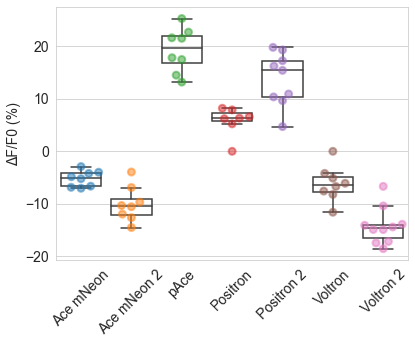

In [19]:
plt.figure(figsize=[6,5])
plt.rc('font', size=14)
sns.set_style("whitegrid")
ax = sns.boxplot(x='Construct',y='dFF_Ben_percent',data=df_T,showfliers = False)
for i in range(len(s)):
    mybox = ax.artists[i]
    r,g,b,a = mybox.get_facecolor()
    mybox.set_facecolor('none')
    mybox.set_linewidth(1.5)
# colors=['g','g','g','y','y','y','y']
# sns.set_palette(sns.color_palette(colors))
sns.swarmplot(x='Construct',y='dFF_Ben_percent',data=df_T,size=7,linewidth=2,alpha=0.5,edgecolor=None)
ax.set_ylabel('\u0394F/F0 (%)',size=14)
ax.set_xlabel('')
plt.xticks(rotation=45,ha='center')
plt.tight_layout()
# plt.savefig('/Users/zhengj10/Desktop/221018/I-clamp_stat.png',dpi=1200)
plt.savefig('/Volumes/genie/Presentations/Jihong/SfN materials/I-clamp.pdf',format='pdf')
plt.show()

In [ ]:
df_s = df_new[df_new['Mutation']=='638.1']
df_s

In [ ]:
h5File = rawPath+'/2022.10.12_000/plate_002/patch_attempt_0034_000/I_clamp1_000/000/Clamp1.ma'
h5Data = h5py.File(h5File,'r')

In [ ]:
ivData = h5Data['data']
ivData.shape

In [ ]:
plt.plot(ivData[0,:])

In [ ]:
df_new.Construct.unique()

In [ ]:
# df_processed = pd.read_pickle(sumPath+'/I-Clamp.pkl')

In [ ]:
# df = df_processed.append(df_new, ignore_index = True)
# df.index = np.arange(1, len(df)+1)
# df.to_pickle(sumPath+'/I-Clamp.pkl')
# df


In [ ]:
# df_new.to_pickle(sumPath+'/I-Clamp.pkl')

In [ ]:
# df = df_new

In [ ]:
# df.to_excel(sumPath+'/iclamp.xlsx')
# df.to_pickle(sumPath+'/iclamp.pkl')

### Plot directly from saved file

In [ ]:
df = pd.read_pickle(sumPath+'/Plot_I-Clamp.pkl')
df.shape

In [ ]:
df

In [ ]:
# df['Objective'] = '40x oil GENIE'

In [ ]:
# df = df.append(df_new, ignore_index = True)
# df.index = np.arange(1, len(df)+1)
# df

In [ ]:
threshold = {'RMP':-40,'AP_AMP':80}

In [ ]:
df_p = df[(df.RMP<threshold['RMP']) & (df.AP_AMP>threshold['AP_AMP'])]
print('%d trials exluded' %(len(df)-len(df_p)))


In [ ]:
df.to_pickle(sumPath+'/I-Clamp.pkl')

#### Check AP shape

In [ ]:
fig=plt.figure(figsize=[14,22])

a = 0
for i,r in df_T.iterrows():
#     print(i)
    ax = plt.subplot(10,7,a+1)
    dataFile = os.path.join(rawPath,r['Date'],r['Plate'],r['Cell'],'I_clamp1_000/000/Clamp1.ma')
    data = h5py.File(dataFile,'r')
    traces = data['data'][()]
    trace = traces[0,:][7300:9300]
#     peaks, _ = ss.find_peaks(trace, height = 0)
#     peaks = np.argmax(trace)
#     print(peaks)
#     peaks = np.argmax(trace)
#     AP_halfWidth = ss.peak_widths(trace,peaks,rel_height=0.5)
#     print(AP_halfWidth)
    ax.plot(trace)
#     ax.scatter(peaks,np.max(trace),color='m')
    ax.set_title(r['Mutation'])
    a+=1
plt.tight_layout()
# fig.savefig('/Volumes/genie/Presentations/Jihong/GENIE production/220614/APs.png',dpi=1200)
plt.show()

In [ ]:
# matFile = '/Volumes/genie/BenArthur/patch-screen/bot/2022.10.12_000/plate_002/patch_attempt_0033_000/999.mat'
# f = h5py.File(matFile,'r')
# d = f['params']['fit']
# st = d[0]
# obj = f[st]
# dFF_trace = obj['bleach_bkg_norm_ave_trace'][()]
# ax = plt.subplot(111)
# ax.plot(dFF_trace)

eFile = '/Volumes/genie/Jihong_GENIE_stuff/PatcherBot/raw/2022.10.12_000/plate_002/patch_attempt_0033_000/I_clamp1_000/000/Clamp1.ma'
f = h5py.File(eFile,'r')
plt.plot(f['data'][0])



In [ ]:
fig=plt.figure(figsize=[14,22])

a = 0
for i,r in df.iterrows():
#     print(i)
    ax = plt.subplot(8,7,a+1)
    matFile = os.path.join(imgPath, r['Date'], r['Plate'], r['Cell'], '999.mat')
    f = h5py.File(matFile,'r')
    d = f['params']['fit']
    st = d[0]
    obj = f[st]
    dFF_trace = obj['bleach_bkg_norm_ave_trace'][()]
    ax.plot(dFF_trace[170:220])
#     ax.scatter(peaks,np.max(trace),color='m')
    ax.set_title(r['Mutation'])
    a+=1
plt.tight_layout()
# fig.savefig('/Volumes/genie/Presentations/Jihong/GENIE production/220614/dFF_sinle AP.png',dpi=1200)
plt.show()

#### Delete cells with bad AP profile

In [ ]:
print(len(df_p))
indexName = df_p[(df_p['Date'] == '2020.09.23_000') & (df_p['Plate'] == 'plate_000') & (df_p['Cell'] == 'patch_attempt_0003_000')].index
indexName
df_p = df_p.drop(indexName)
pd.set_option('display.max_rows', 100)
df_p.shape

In [ ]:
sensors = df_p.Mutation.unique()
sensors
for sensor in sensors:
    print(sensor + ': %d' %len(df_p[df_p['Mutation']==sensor]))

In [ ]:
# sensors = ['485.6','376.20950','485.20950','L2','533.1']
sensors = ['421.1','421.2096']


In [ ]:
import unicodedata

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42



sns.reset_orig()
# fig = plt.figure(figsize=(3.5,8))
fig = plt.figure(figsize=(1.6,2))
# fig = plt.figure(figsize=(6,15))

labels_dict = {
    '485.6':'ASAP3b-TS-ER-SOM2',
    '485.20950':'ASAP3b (T392V)-TS-ER-SOM2',
    '376.20950':'ASAP3b (T392V)',
    'L2':'ASAP3b (T392V)-GSS3-SOM2-lTlcnC',
    '533.1':'ASAP3-Kv (Lin)',
    'A122D-ST':'Voltron (A122D)-TS-ER-SOM2',
    '421.1':'Voltron',
    '421.2096':'Voltron 2'
}
# colors={'421.1':'xkcd:french blue','421.2096':'xkcd:dusty red'}
params = ['dFF_Jihong']
y_label = [unicodedata.lookup("GREEK CAPITAL LETTER delta")+'F/F (%)']
for f in range(len(params)):
    ax = plt.subplot(1,1,f+1)
    individual_points = []
    mean_all = []
    sem_all = []
    labels = []
    for sensor in sensors:
        print(sensor)
        df_sensor = df_p[df_p.Mutation == sensor]
#         param_mean = np.nanmean(df_sensor[params[f]].tolist(), axis=0)
        param_mean = df_sensor[params[f]].mean()
        print(param_mean)
#         print(param_mean)
#         param_sem = np.nanstd(df_sensor[params[f]].tolist(), axis=0)/np.sqrt(len(df_sensor))
        param_sem = df_sensor[params[f]].sem()
        print(param_sem)
        individual_points.append(np.array(df_sensor[params[f]].tolist())*100)
        mean_all.append(param_mean*100)
        sem_all.append(param_sem*100)
        labels.append(labels_dict[sensor])
        x = df_sensor.Mutation.to_list()
        y = df_sensor[params[0]].to_list()
#         ax.scatter(x,y,edgecolor=colors[sensor],s=50,facecolors='none')
        
    y_pos = np.arange(1,len(sensors)+1)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)


    ax.set_ylabel(y_label[0])
    

#     ax.set_ylim([-0.0027,0.0005])
#     ax.set_ylim([-0.0042,0])
#     ax.set_ylim([-0.0021,0])

    
#     ax.bar(y_pos, mean_all, yerr = sem_all,edgecolor=['xkcd:french blue','xkcd:dusty red'],facecolor='none')
    ax.bar(y_pos, mean_all, yerr = sem_all,color=['#336699','#F33333'],edgecolor='k',linewidth=2,zorder=-1)
#     ax.scatter([1,1,1,1,1],individual_points[0],color='k',zorder=1,alpha=0.75)
#     ax.scatter([2,2,2,2,2,2,2],individual_points[1],color='k',zorder=1,alpha=0.75)
    
#     color=['xkcd:french blue','xkcd:dusty red','#2ca02c','#d62728','#9467bd','#17becf','#e377c2','#7f7f7f','#bcbd22']

#     plt.xticks(y_pos,labels,size=12,rotation=90)
#     plt.xticks(y_pos,labels,rotation=45,ha='right')
    
    plt.tick_params(
        axis='x',
        which='both',
        bottom=False,
        top=False,
        labelbottom=False,
    )
    
    colors = ['#336699', '#FF3333']
    for xtick, color in zip(ax.get_xticklabels(), colors):
        xtick.set_color(color)
    
#     plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
#     ax.get_yaxis().get_offset_text().set_position((-0.06,0)) # Adjust position of 1e-3 notation, only x works!

ax.set_ylim([0.0,-12.14354176909621])
plt.tight_layout()
# fig.savefig(sumPath+'/I_Clamp_stat.pdf',format='pdf')
plt.show()


In [ ]:
individual_points

In [ ]:
ax.get_xlim()

In [ ]:
from scipy.stats import mannwhitneyu
p_val = {}

a = df[df['Mutation']=='421.1']['dFF_Jihong'].to_list()
b = df[df['Mutation']=='421.2096']['dFF_Jihong'].to_list()
stat, p = mannwhitneyu(a, b, alternative='two-sided')
# p_val[param] = p

In [ ]:
p

In [ ]:
df_sel = df_p[df_p.Mutation.isin(['421.1','421.2096'])]

In [ ]:
df_sel.shape
# df_sel.Date.unique()
df_sel

#### Pick up example neuron

In [ ]:
fig = plt.figure(figsize=[15,15])

a = 1

for idx,r in df_sel.iterrows():

    img = os.path.join(rawPath,r['Date'],r['Plate'],r['Cell'],'fluor_image_000.tif')
    img = tff.TiffFile(img)
    img = img.asarray()
    img = img[192:320,192:320]

    dataFile = os.path.join(rawPath,r['Date'],r['Plate'],r['Cell'],'I_clamp1_000/000/Clamp1.ma')
    data = h5py.File(dataFile,'r')
    traces = data['data'][()]
    traces[1,:] = traces[1,:]*1e3
    traces[1,8000:8080] = traces[1,8000:8080] - r['Rs_uncorrected']
    trace = traces[1,:][7980:8150]
    if a<=6:
        ax1 = plt.subplot(6,6,a)
        ax1.imshow(img,cmap='gray')
        ax2 = plt.subplot(6,6,a+6)
        ax2.plot(trace)
    elif 6<a<=12:
        ax1 = plt.subplot(6,6,a+6)
        ax1.imshow(img,cmap='gray')
        ax2 = plt.subplot(6,6,a+12)
        ax2.plot(trace)
    else:
        ax1 = plt.subplot(6,6,a+12)
        ax1.imshow(img,cmap='gray')
        ax2 = plt.subplot(6,6,a+18)
        ax2.plot(trace)
    ax1.set_title(r['Mutation']+' ('+r['Cell'][-8:-4]+')')

    a+=1
plt.tight_layout()


#### Example neuron

In [ ]:
# example_neuron = '/Volumes/genie/Jihong_GENIE_stuff/PatcherBot/raw/2020.10.01_000/plate_001/patch_attempt_0003_000/'
# example_neuron = '/Volumes/genie/Jihong_GENIE_stuff/PatcherBot/raw/2020.10.01_000/plate_000/patch_attempt_0004_000/'

# example_neuron = '/Users/zhengj10/Desktop/Jihong/'
example_neuron = rawPath + '/2020.10.01_000/plate_000/patch_attempt_0010_000' # For 220316 revision, Voltron
# example_neuron = rawPath + '/2020.10.01_000/plate_001/patch_attempt_0005_000' # For 220316 revision, Voltron 2

In [ ]:
fig=plt.figure(figsize=[2.5,2.5])

ax = plt.subplot(111)
imgFile = os.path.join(example_neuron,'fluor_image_000.tif')
imgFile = tff.TiffFile(imgFile)
imgFile = imgFile.asarray()
ax.imshow(imgFile[206:306,206:306],cmap='gray')
ax.set_axis_off()
# ax.set_title(r['Mutation']+' ('+r['Cell'][-8:-4]+')')
# ax.plot([75,90.38],[90,90],color='w',lw=3)
# plt.tight_layout()
# fig.savefig(sumPath + '/Voltron 2_image.pdf',format='pdf')
plt.show()
# print(np.min(imgFile[206:306,206:306]))
# print(np.max(imgFile[206:306,206:306]))


In [ ]:
# df[df.Date=='2020.10.01_000']

In [ ]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

sns.set()
sns.set_style(style='whitegrid')
fig = plt.figure(figsize=(2.2,1.8))


ax = plt.subplot(111)
trace_all = []
for trial in range(10):
    dataFile = os.path.join(example_neuron,'I_clamp1_000',str(trial).zfill(3),'Clamp1.ma')
    data = h5py.File(dataFile,'r')
    traces = data['data'][()]
    traces = traces*1000 # converted to mV
    trace_all.append(traces[1,:])
trace_mean = np.mean(trace_all,axis=0)

trace_AP_seg_corrected = trace_mean[8000:8080]-2*0.522519
trace_mean[8000:8080] = trace_AP_seg_corrected

x = np.linspace(0,100,4000)

ax.plot(x,trace_mean[7200:11200],color = '#336699')
# ax.plot(x,trace_mean[7200:11200],color = '#FF3333')
ax.set_ylim([-72.90477247315293, 54.28206798775647])
# ax.set_xlabel('ms')
ax.set_ylabel('Vm (mV)')
plt.tight_layout()
fig.savefig(sumPath + '/Voltron_AP_trace.pdf',format='pdf')
plt.show()
# (-71.83302522359241, 75.78852957710492)
ax.get_ylim()


In [ ]:
ax.get_ylim()

In [ ]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import unicodedata
sns.set_style(style='whitegrid')
fig = plt.figure(figsize=(2.2,1.6))

y_label = [unicodedata.lookup("GREEK CAPITAL LETTER delta")+'F/F']
ax = plt.subplot(111)
dff_all = []
for trial in range(10):
    dataFile = os.path.join(example_neuron,'I_clamp1_000',str(trial).zfill(3),'Camera','frames.ma')
    data = h5py.File(dataFile,'r')
    dff,dff_peak,f_peak_idx,f,f0 = get_dff(dataFile)
    dff_all.append(dff[:1800])
dff_mean = np.mean(dff_all,axis=0)*100
# dff_mean = dff_mean
x = np.linspace(1,100,95)

ax.plot(x,dff_mean[154:249],color='#336699')
# ax.plot(x,dff_mean[154:249],color='#FF3333')
ax.set_ylabel(y_label[0]+' (%)')
# ax.set_ylim([-0.0982281514349218, 0.037823283282636435])
ax.set_ylim([-9.82281514349218, 3.7823283282636434])
plt.tight_layout()
fig.savefig(sumPath + '/Voltron_dFF_single_AP.pdf',format='pdf')
plt.show()
# ax.get_ylim()

In [ ]:
ax.get_ylim()

In [ ]:
import matplotlib

In [ ]:
# df[df.Mutation=='421.2096']